# Presto Demo
Presto is a fast product recommendation algorithm that can process millions of reviews in milliseconds, providing recommendations similar to the 'users who liked this product also liked' recommendations on an e-commerce site.

This notebook simulates how Presto would work on a production website. Just enter a category (Books, Albums, Artists, or Authors) and a search term to receive instant product recommendations based on millions of user reviews.

For more details on how Presto works, see the numbered notebooks in the presto folder.

In [17]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%autoreload 
%run presto/demo_implementation.ipynb
conn = q.connect('presto/data/products.sql')


find_products: 1 results in 0.059 seconds
0.0688: Found 1 products
0.111: Got 4118 reviews
0.113: Filtered 3598 helpful reviews
0.584: Got 40199 related reviews of 12462 products by 2961 users
0.585: Filtered 37188 helpful related reviews
0.599: Filtered 6156 related reviews by user and/or product
0.609: Created ratings table for 1000 products by 100 users
0.635: Calculated similarities
0.823: Removed 90 duplicate editions of the same product
0.824: Added product details
Found The Hobbit recommendations in 0.825 seconds


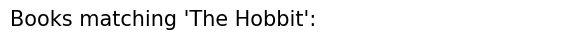

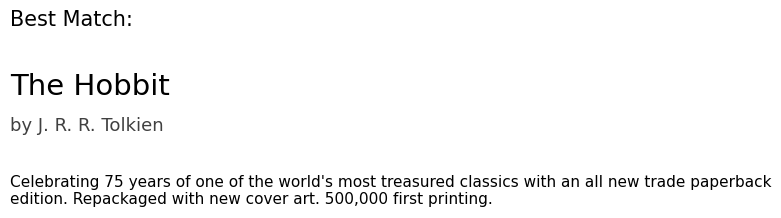

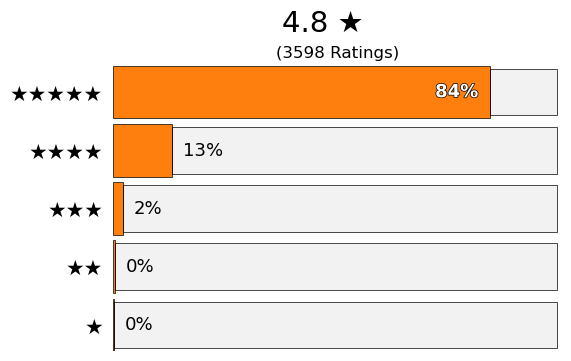

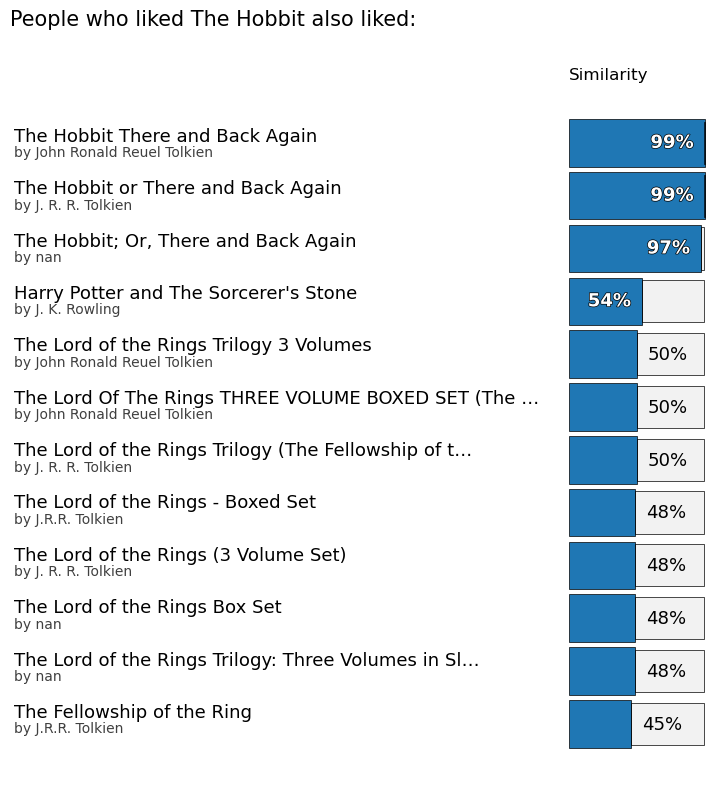

In [ ]:
# Search input. These are intended as user-facing inputs.
type = 'Book' # possibilities: Book, Album, Artist, Author
search = "The Hobbit"
exact_match = False

# recommender settings
# feel free to experiment with these to see how results change.
max_search_results = 10 # Relevant in case of ambiguous search terms with multiple hits. Presto will resolve ambiguity by selecting the most-reviewd product
max_recommendations = 12 # How many of Presto's related products to display to the usser
recommender_user_pool_size = 100 # For large numbers of user reviews, consider only this many users for recommendations. Filters by users who leave the most reviews.
recommender_product_pool_size = 100 # For large numbers of user reviews, consider only this many products for recommendations. Filters by number of reviews

log_verbosity = 1 # Increase to see internal details
include_subtitles = True

###################################
# Recommendations
##################################
results = output_recommendations(type, search, exact_match, conn = conn, include_subtitles = include_subtitles)

In [ ]:
# Explore the internals of the results in more detail if needed:
product = results['result']
products = results['results']
recommendations = results['recommendations']
product

In [ ]:
products

In [ ]:
recommendations

In [ ]:
# Don' forget to clean up
conn.close()